# Classification model: T5

This notebook contains T5 model building, training and evaluation.

### Install missing dependencies

In [3]:
!pip install torchtext

  Obtaining dependency information for torchtext from https://files.pythonhosted.org/packages/91/8e/d65632f1398d9b343f50f528bd8f6bf9b8a64c15731c1f2752c249559fb7/torchtext-0.16.2-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for torch==2.1.2 from https://files.pythonhosted.org/packages/1e/86/477ec85bf1f122931f00a2f3889ed9322c091497415a563291ffc119dacc/torch-2.1.2-cp311-none-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for torchdata==0.7.1 from https://files.pythonhosted.org/packages/35/b2/7ed3a80ae0673b940f2af14281dc02dee0f667c6094e6dcd399fa35249a7/torchdata-0.7.1-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 5.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 MB 9.5 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 6.9 MB/s eta 0:00:00a 0:00:01m
DEPRECATION: pytorch-lightning 1.5.10 has a non-standard dependency specif

In [1]:
import numpy as np
import pandas as pd
import math
import json
import time
import datetime

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
import keras_nlp
import tensorflow.keras.backend as K
from tensorflow.keras.layers import TextVectorization

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
import torch.utils.data as data_utils

from transformers import T5Tokenizer, T5ForConditionalGeneration

from torch.utils.data import TensorDataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

Using TensorFlow backend


### Read the splitted datasets

In [3]:
with open('./datasets/data_train_new.json', 'r') as f:
    data_train = json.load(f)

with open('./datasets/data_valid_new.json', 'r') as f:
    data_valid = json.load(f)

with open('./datasets/data_test_new.json', 'r') as f:
    data_test = json.load(f)

train_df = pd.DataFrame(data_train)
valid_df = pd.DataFrame(data_valid)
test_df = pd.DataFrame(data_test)

### Model building

In [4]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')

def tokenize_corpus(df, tokenizer, max_len):
    # token ID storage
    input_ids = []
    # attension mask storage
    attention_masks = []
    # for every document:
    for doc in df:
        encoded_dict = tokenizer.encode_plus(
                            doc,  # document to encode.
                            add_special_tokens=True,  # add tokens relative to model
                            max_length=max_len,  # set max length
                            truncation=True,  # truncate longer messages
                            pad_to_max_length=True,  # add padding
                            return_attention_mask=True,  # create attn. masks
                            return_tensors='pt'  # return pytorch tensors
                       )

        # add the tokenized sentence to the list
        input_ids.append(encoded_dict['input_ids'])

        # and its attention mask (differentiates padding from non-padding)
        attention_masks.append(encoded_dict['attention_mask'])

    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

def create_dataset(df):
    body_input_ids, body_attention_masks = tokenize_corpus(df['text'].values.tolist(), tokenizer, 128)
    target_input_ids, target_attention_masks = tokenize_corpus([str(each) for each in df['label'].values.tolist()], tokenizer, 2)
    
    return TensorDataset(body_input_ids, body_attention_masks, target_input_ids, target_attention_masks)

In [5]:
train_dataset = create_dataset(train_df)
valid_dataset = create_dataset(valid_df)
test_dataset = create_dataset(test_df)

/Users/d3lph1/university/3/anlp/2/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [6]:
model = T5ForConditionalGeneration.from_pretrained('t5-small')

In [7]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=24,
                              shuffle=False)

valid_dataloader = DataLoader(valid_dataset,
                              batch_size=24,
                              shuffle=True)

test_dataloader = DataLoader(test_dataset,
                              batch_size=24,
                              shuffle=True)

In [12]:
def train(model, dataloader, optimizer):

    # capture time
    total_t0 = time.time()

    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
    print('Training...')

    # reset total loss for epoch
    train_total_loss = 0
    total_train_f1 = 0

    # put model into traning mode
    model.train()

    # for each batch of training data...
    for step, batch in enumerate(dataloader):

        # progress update every 40 batches.
        if step % 40 == 0 and not step == 0:

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(dataloader)))

        # Unpack this training batch from our dataloader
        b_input_ids = batch[0]
        b_input_mask = batch[1]
        b_target_ids = batch[2]
        b_target_mask = batch[3]

        # clear previously calculated gradients
        optimizer.zero_grad()

        # forward propagation (evaluate model on training batch)
        outputs = model(input_ids=b_input_ids,
                        attention_mask=b_input_mask,
                        labels=b_target_ids,
                        decoder_attention_mask=b_target_mask)

        loss, prediction_scores = outputs[:2]

        # sum the training loss over all batches for average loss at end
        # loss is a tensor containing a single value
        train_total_loss += loss.item()

        optimizer.step()

        # update the learning rate
        scheduler.step()

    # calculate the average loss over all of the batches
    avg_train_loss = train_total_loss / len(dataloader)

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'Train Loss': avg_train_loss
        }
    )

    # training time end
    training_time = format_time(time.time() - total_t0)

    # print result summaries
    print("")
    print("summary results")
    print("epoch | trn loss | trn time ")
    print(f"{epoch+1:5d} | {avg_train_loss:.5f} | {training_time:}")

    return training_stats

def validating(model, dataloader):

    # capture validation time
    total_t0 = time.time()

    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")

    # put the model in evaluation mode
    model.eval()

    # track variables
    total_valid_loss = 0

    # evaluate data for one epoch
    for batch in dataloader:

        # Unpack this training batch from our dataloader
        b_input_ids = batch[0]
        b_input_mask = batch[1]
        b_target_ids = batch[2]
        b_target_mask = batch[3]

        with torch.no_grad():

            # forward propagation
            outputs = model(input_ids=b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_target_ids,
                            decoder_attention_mask=b_target_mask)

            loss, prediction_scores = outputs[:2]

            total_valid_loss += loss.item()

    global avg_val_loss
    avg_val_loss = total_valid_loss / len(dataloader)

    # Record all statistics from this epoch.
    valid_stats.append(
        {
            'Val Loss': avg_val_loss,
            'Val PPL.': np.exp(avg_val_loss)
        }
    )

    training_time = format_time(time.time() - total_t0)

    print("")
    print("summary results")
    print("epoch | val loss | val time")
    print(f"{epoch+1:5d} | {avg_val_loss:.5f} | {training_time:}")

    return valid_stats

def testing(model, dataloader):

    print("")
    print("Running Testing...")

    t0 = time.time()

    model.eval()

    total_test_loss = 0
    total_test_acc = 0
    total_test_f1 = 0
    predictions = []
    actuals = []

    for step, batch in enumerate(dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(dataloader), elapsed))

        # Unpack this training batch from our dataloader
        b_input_ids = batch[0]
        b_input_mask = batch[1]
        b_target_ids = batch[2]
        b_target_mask = batch[3]

        with torch.no_grad():
            outputs = model(input_ids=b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_target_ids,
                            decoder_attention_mask=b_target_mask)

            loss, prediction_scores = outputs[:2]

            total_test_loss += loss.item()

            generated_ids = model.generate(
                    input_ids=b_input_ids,
                    attention_mask=b_input_mask,
                    max_length=2
            )

            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
            target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True) for t in b_target_ids]

            total_test_acc += accuracy_score(target, preds)
            total_test_f1 += f1_score(preds, target,
                                       average='weighted',
                                       labels=np.unique(preds))
            predictions.extend(preds)
            actuals.extend(target)

    avg_test_loss = total_test_loss / len(dataloader)

    avg_test_acc = total_test_acc / len(test_dataloader)

    avg_test_f1 = total_test_f1 / len(test_dataloader)

    test_stats = (
        {
            'Test Loss': avg_test_loss,
            'Test Acc.': avg_test_acc
        }
    )

    return test_stats, predictions, actuals

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

### Train the model

In [9]:
optimizer = AdamW(model.parameters(),
                  lr = 3e-5
                  )

# epochs
epochs = 6

# lr scheduler
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

/Users/d3lph1/university/3/anlp/2/lib/python3.11/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
training_stats = []
valid_stats = []
best_valid_loss = float('inf')

for epoch in range(epochs):

    train(model, train_dataloader, optimizer)
    validating(model, valid_dataloader)

    if valid_stats[epoch]['Val Loss'] < best_valid_loss:
        best_valid_loss = valid_stats[epoch]['Val Loss']

        torch.save(model.state_dict(), 't5-classification.pt')
        model_to_save = model.module if hasattr(model, 'module') else model
        model_to_save.save_pretrained('./model_save/t5-classification/')
        tokenizer.save_pretrained('./model_save/t5-classification/')


======== Epoch 1 / 6 ========
Training...
  Batch    40  of     94.
  Batch    80  of     94.

summary results
epoch | trn loss | trn time 
    1 | 0.7215 | 0:04:38

Running Validation...

summary results
epoch | val loss | val time
    1 | 0.8094 | 0:00:47

======== Epoch 2 / 6 ========
Training...
  Batch    40  of     94.
  Batch    80  of     94.

summary results
epoch | trn loss | trn time 
    2 | 0.5694 | 0:04:30

Running Validation...

summary results
epoch | val loss |  val time
    2 | 0.8213 | 0:00:53

======== Epoch 3 / 6 ========
Training...
  Batch    40  of     94.
  Batch    80  of     94.

summary results
epoch | trn loss | trn time 
    3 | 0.5015 | 0:04:36

Running Validation...

summary results
epoch | val loss | val time
    3 | 0.3927 | 0:00:50

======== Epoch 4 / 6 ========
Training...
  Batch    40  of     94.
  Batch    80  of     94.

summary results
epoch | trn loss | trn time 
    4 | 0.3257 | 0:04:52

Running Validation...

summary results
epoch | val loss

### Evaluation on the test dataset

In [13]:
stat, pred, true = testing(model, test_dataloader)


Running Testing...


In [14]:
stat

{'Test Loss': 0.27349,
 'Test Acc.': 0.84512}


In [22]:
true_labels = np.array(true).reshape((-1))
pred_labels = np.array(pred).reshape((-1))

In [23]:
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [25]:
pred_labels

array([0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 1, 2, 0, 1, 2,
       0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0,
       2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 2, 1, 1, 0, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2,

### Metrics

In [17]:
accuracy_score(true_labels, pred_labels), precision_score(true_labels, pred_labels, average='macro'), recall_score(true_labels, pred_labels, average='macro')

(0.8453333333333334, 0.8554169656550307, 0.8453333333333334)

### Confusion matrix

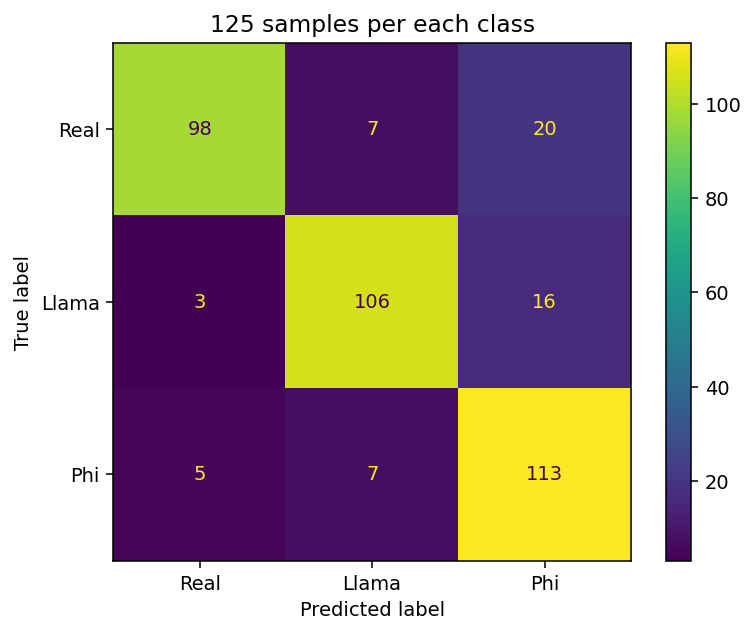

In [18]:
mpl.rcParams['figure.dpi'] = 140

cm = confusion_matrix(true_labels, pred_labels, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Llama', 'Phi'])
disp.plot()

plt.title('125 samples per each class')
plt.show()